In [7]:
import tensorflow as pd
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# DEFINE PATHS
train_dir = 'dataset/train'  
test_dir = 'dataset/test'
val_dir = 'dataset/val'

# CONFIGURATION
# Resize images to 224x224 because ResNet50 expects this size.
IMG_SIZE = (224, 224) 
BATCH_SIZE = 32

In [8]:
# DATA AUGMENTATION 
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Preprocess input for ResNet50 
    rotation_range=20,     # Randomly rotate image by up to 20 degrees
    shear_range=0.2,       # Randomly shear (distort) the image
    zoom_range=0.2,        # Randomly zoom in
    horizontal_flip=True,  # Randomly flip horizontally
    fill_mode='nearest'    # How to fill new pixels created by rotation/shearing
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input 
)

# LOAD DATA FROM FOLDERS
print("Loading Training Data:")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary' # Binary classification
)

print("Loading Validation Data:")
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

print("Loading Test Data:")
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Do not shuffle for evaluation purposes
)

Loading Training Data:
Found 5216 images belonging to 2 classes.
Loading Validation Data:
Found 16 images belonging to 2 classes.
Loading Test Data:
Found 624 images belonging to 2 classes.


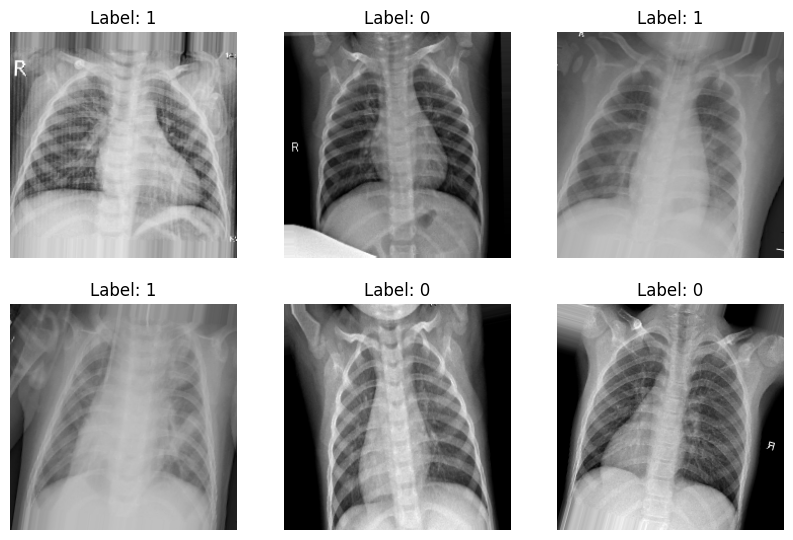

In [3]:
# VISUALIZE SOME AUGMENTED IMAGES

# Get a batch of images
images, labels = next(train_generator)

# Plot the first 6 images 
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}") # 0 = Normal, 1 = Pneumonia
    plt.axis('off')
plt.show()

In [ ]:
# BUILDING THE CUSTOM CNN MODEL

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 1. INITIALIZE THE MODEL
model = Sequential()

# 2. ADD CONVOLUTIONAL LAYERS (Feature Extraction)
# Layer 1: Look for simple features (edges, lines)
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Look for more complex features (shapes, textures)
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Look for deep patterns (specific pneumonia opacities)
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3. FLATTEN AND DENSE LAYERS (Classification)
model.add(Flatten()) # Convert the 2D feature maps into a 1D vector

# Fully Connected Layer
model.add(Dense(128, activation='relu'))

# Dropout Layer ("preventing overfitting")
# randomly shuts off 50% of neurons during training to force the model to learn redundant paths, making it more robust.
model.add(Dropout(0.5)) 

# Output Layer
# 'sigmoid' because we want a probability between 0 and 1.
# < 0.5 = Normal, > 0.5 = Pneumonia
model.add(Dense(1, activation='sigmoid')) 

# 4. VIEW THE ARCHITECTURE
model.summary()

d:\Tech\DS & ML\Pneumonia-Detection-from-Chest-X-Ray-Images\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# TRAINING THE MODEL

# 1. COMPILE
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 2. TRAIN 
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE, 
    epochs=10, 
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

# 3. SAVE THE MODEL
model.save('models/cnn_pneumonia_model.h5')

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 430s 3s/step - accuracy: 0.8129 - loss: 0.4188 - val_accuracy: 0.5000 - val_loss: 0.9981
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.8737 - loss: 0.2894 - val_accuracy: 0.7500 - val_loss: 0.6397
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.8936 - loss: 0.2533 - val_accuracy: 0.6875 - val_loss: 0.7001
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.8905 - loss: 0.2550 - val_accuracy: 0.8125 - val_loss: 0.4033
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.9082 - loss: 0.2303 - val_accuracy: 0.6250 - val_loss: 1.5062
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.9087 - loss: 0.2274 - val_accuracy: 0.6250 - val_loss: 1.0771
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4217s 26s/step - accuracy: 0.9178 - loss: 0.2029 - val_accuracy: 0.6875 - val_loss: 0.5273
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9245 - loss: 0.1997 - val_ac

In [9]:
# TRANSFER LEARNING WITH RESNET50

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. LOAD THE PRE-TRAINED BASE MODEL
# weights='imagenet': Download the knowledge learned from 14M images.
# include_top=False: Drop the "head" (the final classification layer). 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. FREEZE THE BASE LAYERS
base_model.trainable = False

# Now, unfreeze ONLY the last few layers (the last "convolutional block")
for layer in base_model.layers[-10:]:
    layer.trainable = True

# 3. ADD OUR CUSTOM HEAD (The "Pneumonia" Specialist)
x = base_model.output

# GlobalAveragePooling2D
x = GlobalAveragePooling2D()(x) 

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) # keep dropout for robustness
predictions = Dense(1, activation='sigmoid')(x)

# 4. COMBINE BASE AND HEAD
model = Model(inputs=base_model.input, outputs=predictions)

# 5. COMPILE
# Use a lower learning rate (1e-5) for transfer learning to avoid making sudden, drastic changes to the weights.
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 6. TRAIN 
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32
)

model.save('models/resnet50_pneumonia_model.h5')

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.8457 - loss: 0.3489 - val_accuracy: 0.7730 - val_loss: 0.4319
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.9239 - loss: 0.2021 - val_accuracy: 0.8405 - val_loss: 0.3620
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 492s 3s/step - accuracy: 0.9385 - loss: 0.1533 - val_accuracy: 0.8586 - val_loss: 0.3302
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.9523 - loss: 0.1331 - val_accuracy: 0.8750 - val_loss: 0.3127
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 452s 3s/step - accuracy: 0.9626 - loss: 0.1104 - val_accuracy: 0.8849 - val_loss: 0.2998
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.9626 - loss: 0.1020 - val_accuracy: 0.8783 - val_loss: 0.3183
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.9617 - loss: 0.1023 - val_accuracy: 0.8882 - val_loss: 0.2944
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.9686 - loss: 0.0889 - val_accu

Generating predictions...
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step

--- Classification Report ---
              precision    recall  f1-score   support

      Normal       0.94      0.76      0.84       234
   Pneumonia       0.87      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624



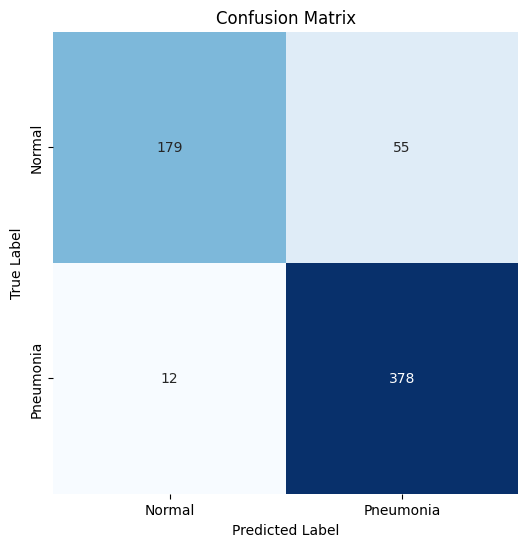

In [11]:
# EVALUATING THE MODEL

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. GENERATE PREDICTIONS
# We use the test_generator 
print("Generating predictions...")
predictions = model.predict(test_generator, steps=test_generator.samples // 32 + 1)

# If probability > 0.5, it's Pneumonia (1), else Normal (0)
y_pred = (predictions > 0.5).astype(int).ravel()

# Get the true labels from the generator
# The generator might loop, so we slice it to match the number of predictions
y_true = test_generator.classes[:len(y_pred)]

# 2. CALCULATE METRICS
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# 3. CONFUSION MATRIX VISUALIZATION
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()